# Predicting Online Purchasing Behaviors

This project analyzes online shopping behavior for a new e-commerce website, focusing on November and December, the busiest months. It identifies two key customer groups: low purchase rate shoppers and returning customers.

The goal is to estimate their likelihood of purchasing in an upcoming marketing campaign to guide future sales strategies.

The dataset includes fields for each shopping session, with each session corresponding to a single user.

|Column|Description|
|--------|-----------|
|`SessionID`|unique session ID|
|`Administrative`|number of pages visited related to the customer account|
|`Administrative_Duration`|total amount of time spent (in seconds) on administrative pages|
|`Informational`|number of pages visited related to the website and the company|
|`Informational_Duration`|total amount of time spent (in seconds) on informational pages|
|`ProductRelated`|number of pages visited related to available products|
|`ProductRelated_Duration`|total amount of time spent (in seconds) on product-related pages|
|`BounceRates`|average bounce rate of pages visited by the customer|
|`ExitRates`|average exit rate of pages visited by the customer|
|`PageValues`|average page value of pages visited by the customer|
|`SpecialDay`|closeness of the site visiting time to a specific special day|
|`Weekend`|indicator whether the session is on a weekend|
|`Month`|month of the session date|
|`CustomerType`|customer type|
|`Purchase`|class label whether the customer make a purchase|

## Loading the data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load and view your data
shopping_data = pd.read_csv("online_shopping_session_data.csv")
shopping_data.head()

,SessionID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month,CustomerType,Purchase
0,1,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb,Returning_Customer,0.0
1,2,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,False,Feb,Returning_Customer,0.0
2,3,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb,Returning_Customer,0.0
3,4,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,False,Feb,Returning_Customer,0.0
4,5,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,True,Feb,Returning_Customer,0.0


## Data Preparation

In [2]:
# Filter data for November and December
holiday_season_data = shopping_data[shopping_data["Month"].isin(["Nov", "Dec"])]

## Online Purchase Rates by Customer Type

Numbers suggest that returning customers are more likely to complete a purchase, which aligns with typical e-commerce behavior where repeat customers tend to be more engaged and have higher conversion rates.

In [3]:
# Frequency of sessions by customer type
purchase_rates = holiday_season_data.groupby("CustomerType")["Purchase"].value_counts()

# Total number of session by Customer Type
total_new = purchase_rates['New_Customer'].sum()
total_returning = purchase_rates['Returning_Customer'].sum()

# Total number of purchase by Customer Type
purchases_new = purchase_rates[('New_Customer', 1)]
purchases_returning = purchase_rates[('Returning_Customer', 1)]

In [4]:
# Purchase rates by customer type

purchase_rates = {
    "Returning_Customer": purchases_returning / total_returning,
    "New_Customer": purchases_new / total_new
}

print("Purchase Rates:", purchase_rates)

Purchase Rates: {'Returning_Customer': 0.1955937667920473, 'New_Customer': 0.2733516483516483}


## Correlation Among Duration Variables

In [5]:
# Strongest correlation among relevant duration variables

corr_admin_info = holiday_season_data['Administrative_Duration'].corr(holiday_season_data ['Informational_Duration'])
corr_admin_product = holiday_season_data['Administrative_Duration'].corr(holiday_season_data ['ProductRelated_Duration'])
corr_product_info = holiday_season_data['ProductRelated_Duration'].corr(holiday_season_data ['Informational_Duration'])

print('corr_admin_info', corr_admin_info)
print('corr_admin_product', corr_admin_product)
print('corr_product_info', corr_product_info)

corr_admin_info 0.24468855792839267
corr_admin_product 0.3898546003206963
corr_product_info 0.36712552534442133


In [6]:
correlation_matrix = holiday_season_data[['Administrative_Duration','Informational_Duration','ProductRelated_Duration' ]].corr()
correlation_matrix

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
Administrative_Duration,1.000000,0.244689,0.389855
Informational_Duration,0.244689,1.000000,0.367126
ProductRelated_Duration,0.389855,0.367126,1.000000


The correlation of 0.3899 between Administrative Duration and Product Related Duration suggests a moderate relationship, meaning customers who spend more time on one type of page tend to spend more on the other. However, other factors may also influence this behavior. Further analysis could reveal specific customer patterns or segments driving this correlation.

## Probability Analysis of Sales

The probability of achieving at least 100 sales out of 500 sessions was calculated using a binomial distribution. If this probability is high, it suggests that a small boost in purchase rate could significantly impact total sales. If low, it may indicate that other strategies (e.g. better product recommendations, pricing adjustments) are needed to achieve higher conversions.\

We have high probability value of 0.9190

In [7]:
import scipy.stats as stats

# New campaign to boost purchase rate by 15%
boosted_rate = purchase_rates["Returning_Customer"] * 1.15

# Likelihood of having <100 sales of 500 sessions
prob_sales_100_less = stats.binom.cdf(99, 500, boosted_rate)

# Likelihood of having 100 or more sales
prob_at_least_100_sales = 1 - stats.binom.cdf(99, 500, boosted_rate)

print("Probability of at least 100 sales:", prob_at_least_100_sales)

Probability of at least 100 sales: 0.9190464150313484


## Association Rule Mining: Key Browsing Patterns

The Association Rule Mining analyzes customer browsing behavior to uncover patterns in how users interact with different types of pages. The Apriori algorithm is applied to find frequently visited combinations of page types (Administrative, Informational, and ProductRelated pages), and the association rules derived from this help identify which types of pages are most likely to be visited together.

In [8]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert browsing behavior (page visits) into a boolean format to be interpretted transactionally
transactions = holiday_season_data[['Administrative', 'Informational', 'ProductRelated']].astype(bool)

# Apriori - Frequent itemsets with a minimum support threshold of 5% are identified. Only page combinations appearing in at least 5% of user sessions are considered.
frequent_itemsets = apriori(transactions, min_support=0.05, use_colnames=True)

# Association - Lift metric is used to measure how much more likely one event (e.g., visiting the "ProductRelated" page) is to occur when another event happens. A lift > 1.0 suggests a strong positive association.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [9]:
# Display top rules
print("Top Association Rules:")
print(rules.sort_values(by='lift', ascending=False).head())

Top Association Rules:
                        antecedents                       consequents  \
6   (Informational, ProductRelated)                  (Administrative)   
7                  (Administrative)   (Informational, ProductRelated)   
5  (Administrative, ProductRelated)                   (Informational)   
8                   (Informational)  (Administrative, ProductRelated)   
0                  (Administrative)                   (Informational)   

   antecedent support  consequent support   support  confidence      lift  \
6            0.241573            0.540674  0.196854    0.814884  1.507162   
7            0.540674            0.241573  0.196854    0.364090  1.507162   
5            0.539101            0.242921  0.196854    0.365152  1.503170   
8            0.242921            0.539101  0.196854    0.810361  1.503170   
0            0.540674            0.242921  0.196854    0.364090  1.498797   

   representativity  leverage  conviction  zhangs_metric   jaccard  certain

If a customer visits Informational pages, they are likely to visit Product pages.

Customers who engage with Administrative pages (e.g., checking policies, FAQs) may or may not convert, depending on their browsing sequence.

If certain page types frequently appear together, it can guide website design optimizations such as ensuring a seamless transition from informational content to purchase pages.

## Visualizations

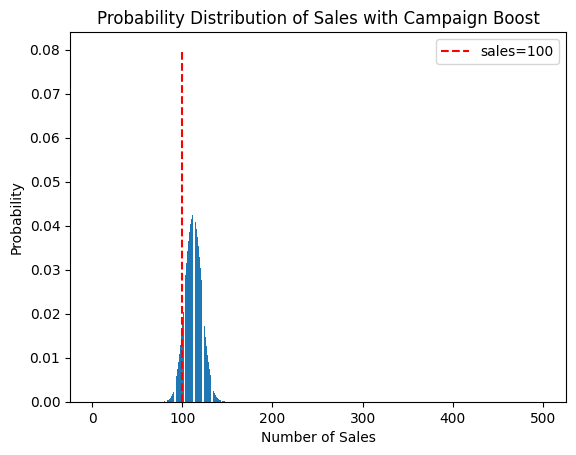

In [11]:
n_sessions = 500
k_values = np.arange(500) + 1
p_binom_values = [stats.binom.pmf(k, n_sessions, boosted_rate) for k in k_values ]
plt.bar(k_values, p_binom_values)
plt.vlines(100, 0, 0.08, color='r', linestyle='dashed', label="sales=100")
plt.xlabel("Number of Sales")
plt.ylabel("Probability")
plt.title("Probability Distribution of Sales with Campaign Boost")
plt.legend()
plt.show()